In [1]:
import sccoda

In [2]:
import seaborn

In [3]:
import warnings

import matplotlib

# import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [4]:
import anndata as ad

In [5]:
import importlib
import warnings

warnings.filterwarnings("ignore")

import pickle as pkl

import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import sccoda.datasets as scd
import sccoda.util.comp_ana as ana
from sccoda.util import cell_composition_data as dat
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz

2024-08-12 13:53:18.285186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 13:53:18.285236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 13:53:18.287411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 13:53:18.296473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from typing import Dict

import numpy as np
import pandas as pd
from anndata import AnnData


def score_seeds(
    adata: AnnData,
    seed_marker_genes: Dict[str, Dict[str, list]],
    layer: str = "log1p_norm",
    cutoff_sum_pos_marker_expression: float = 0.1,
    cutoff_sum_neg_marker_expression: float = 0,
) -> pd.Series:
    """Label seed cell types based on input pos/neg marker gene expression"""

    def _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression):
        tmp_df = pd.DataFrame(index=adata.obs_names)

        for cell_type, markers in seed_marker_genes.items():
            positive_conditions = []
            negative_conditions = []

            for positive_markers_list in markers["positive"]:
                positive_condition = (
                    np.ravel(
                        adata[:, adata.var_names.isin(positive_markers_list)]
                        .layers[layer]
                        .sum(1)
                    )
                    > cutoff_sum_pos_marker_expression
                )
                positive_conditions.append(positive_condition)

            for negative_markers_list in markers["negative"]:
                negative_condition = ~(
                    np.ravel(
                        adata[:, adata.var_names.isin(negative_markers_list)]
                        .layers[layer]
                        .sum(1)
                    )
                    > cutoff_sum_neg_marker_expression
                )
                negative_conditions.append(negative_condition)

            combined_pvositive_condition = np.all(positive_conditions, axis=0)
            combined_negative_condition = np.all(negative_conditions, axis=0)

            condition = combined_positive_condition & combined_negative_condition
            tmp_df[f"tmp_{cell_type}"] = np.where(condition, cell_type, "unknown")

        return tmp_df

    def _combine_ct(row):
        for ct in seed_ct:
            if row[ct] != "unknown":
                return row[ct]
        return "unknown"

    seed_df = _score_ct(
        adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression
    )
    seed_ct = [f"tmp_{ct}" for ct in seed_marker_genes.keys()]

    return seed_df.apply(_combine_ct, axis=1)

In [9]:
def update_columns_condition(row):

    if row["sample_id"] == "10mix1":
        row["condition"] = "10mix"
    elif row["sample_id"] == "10mix2":
        row["condition"] = "10mix"
    elif row["sample_id"] == "11mix1":
        row["condition"] = "11mix"
    elif row["sample_id"] == "11mix2":
        row["condition"] = "11mix"
    elif row["sample_id"] == "GF1":
        row["condition"] = "GF"
    elif row["sample_id"] == "GF2":
        row["condition"] = "GF"
    elif row["sample_id"] == "GF_ICI2_plus":
        row["condition"] = "GF-plus"
    elif row["sample_id"] == "GF_ICI1_plus":
        row["condition"] = "GF-plus"
    elif row["sample_id"] == "GF_ICI2":
        row["condition"] = "GF"
    elif row["sample_id"] == "GF_ICI1":
        row["condition"] = "GF"
    elif row["sample_id"] == "10mix_ICI1":
        row["condition"] = "10mix"
    elif row["sample_id"] == "10mix_ICI2":
        row["condition"] = "10mix"
    elif row["sample_id"] == "11mix_ICI1":
        row["condition"] = "11mix"
    elif row["sample_id"] == "11mix_ICI2":
        row["condition"] = "11mix"

    return row

In [10]:
adata = sc.read_h5ad("adata_solo_annotated_all.h5ad")

In [11]:
adata

AnnData object with n_obs × n_vars = 60459 × 11945
    obs: '_scvi_batch', '_scvi_labels', 'batch', 'batch_id', 'cell_type', 'condition', 'is_doublet', 'is_outlier', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_mito', 'is_outlier_top_20', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'origin', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'sample_id', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'value', 'outlier', 'mt_outlier', 'ribo_outlier'
    var: 'ensembl_id', 'feature_types', 'gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_colors', 'hvg', 'is_doublet_colors', 'leiden', 'leiden_colors', 

In [12]:
adata.obs["origin"]

AAACCTGAGTTAAGTG-1_10mix1          colon
AAACCTGCAGGATCGA-1_10mix1          colon
AAACCTGCATAACCTG-1_10mix1          colon
AAACCTGCATACCATG-1_10mix1          colon
AAACCTGGTGTGCCTG-1_10mix1          colon
                                   ...  
TTTGTCATCCCTTGCA-1_GF_ICI2_plus      til
TTTGTCATCGTTGCCT-1_GF_ICI2_plus      til
TTTGTCATCTAACTGG-1_GF_ICI2_plus      til
TTTGTCATCTCTGTCG-1_GF_ICI2_plus      til
TTTGTCATCTGTTGAG-1_GF_ICI2_plus      til
Name: origin, Length: 60459, dtype: category
Categories (2, object): ['colon', 'til']

In [13]:
adata.layers["counts"] = adata.X
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [14]:
frac_by_condition = (
    adata.obs.groupby(["condition", "sample_id", "origin"])
    .apply(lambda x: x.value_counts("cell_type", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)

In [15]:
frac_by_condition

,condition,sample_id,origin,cell_type,n_cells
0,10mix,10mix1,colon,COLON_Naive,997
1,10mix,10mix1,colon,COLON_Exhausted,686
2,10mix,10mix1,colon,COLON_Infg,312
3,10mix,10mix1,colon,COLON_Intermediate,211
4,10mix,10mix1,colon,MPEC_Effector,0
...,...,...,...,...,...
177,GF-plus,GF_ICI2_plus,til,SLEC_Plastic,80
178,GF-plus,GF_ICI2_plus,til,COLON_Exhausted,0
179,GF-plus,GF_ICI2_plus,til,COLON_Infg,0
180,GF-plus,GF_ICI2_plus,til,COLON_Intermediate,0


In [16]:
# frac_by_condition.to_csv("frac_by_condition.csv")

In [17]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["sample_id", "condition"],
        columns="cell_type",
        values="n_cells",
    ).reset_index()
    # .drop(columns="other")
)

In [18]:
frac_pivot

cell_type,sample_id,condition,COLON_Exhausted,COLON_Infg,COLON_Intermediate,COLON_Naive,MPEC_Effector,MPEC_Intermediate,MPEC_Progenitor,SLEC_Effector,SLEC_Inf,SLEC_Intermediate,SLEC_Plastic,SLEC_Progenitor,SLEC_Terminal
0,10mix1,10mix,686,312,211,997,0,0,0,0,0,0,0,0,0
1,10mix2,10mix,504,257,128,729,0,0,0,0,0,0,0,0,0
2,10mix_ICI1,10mix,0,0,0,0,619,369,389,2428,489,497,42,412,1908
3,10mix_ICI2,10mix,0,0,0,0,3250,139,416,862,714,354,109,578,1711
4,11mix1,11mix,1184,314,133,635,0,0,0,0,0,0,0,0,0
5,11mix2,11mix,1612,408,216,960,0,0,0,0,0,0,0,0,0
6,11mix_ICI1,11mix,0,0,0,0,792,300,105,1823,444,689,69,441,1833
7,11mix_ICI2,11mix,0,0,0,0,2092,258,504,1092,702,297,129,240,1454
8,GF1,GF,61,143,109,1207,0,0,0,0,0,0,0,0,0
9,GF2,GF,0,113,5,225,0,0,0,0,0,0,0,0,0


In [19]:
data_all = dat.from_pandas(frac_pivot, covariate_columns=["condition", "sample_id"])

In [20]:
data_all.obs["condition"] = pd.Categorical(
    data_all.obs["condition"], categories=["10mix", "11mix", "GF"]
)

In [21]:
data_all._sanitize()

In [22]:
data = data_all
feature_name = "sample_id"
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X / sample_sums
value_name = "Proportion"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).merge(
    data.obs[feature_name], left_index=True, right_index=True
)
plot_df = pd.melt(
    count_df, id_vars=feature_name, var_name="cell_type", value_name=value_name
)

In [23]:
plot_df

,sample_id,cell_type,Proportion
0,10mix1,COLON_Exhausted,0.310970
1,10mix2,COLON_Exhausted,0.311496
2,10mix_ICI1,COLON_Exhausted,0.000000
3,10mix_ICI2,COLON_Exhausted,0.000000
4,11mix1,COLON_Exhausted,0.522507
...,...,...,...
177,GF2,SLEC_Terminal,0.000000
178,GF_ICI1,SLEC_Terminal,0.290112
179,GF_ICI1_plus,SLEC_Terminal,0.285654
180,GF_ICI2,SLEC_Terminal,0.220281


In [24]:
# plot_df['condition'] = plot_df['sample_id'].apply(lambda x: '10mix' if '10mix_ICI' in x else ('11mix' if '11mix_ICI' in x else 'GF'))

In [25]:
# Assuming df is your DataFrame
plot_df["condition"] = np.where(
    plot_df["sample_id"].str.contains("11mix"),
    "11mix",
    np.where(
        plot_df["sample_id"].str.contains("10mix"),
        "10mix",
        np.where(plot_df["sample_id"].str.contains("plus"), "GF_ICI", "GF"),
    ),
)

In [26]:
plot_df["treatment"] = plot_df["sample_id"].apply(
    lambda x: "naive" if x in ["GF_ICI1_plus", "GF_ICI2_plus"] else "treated"
)

In [27]:
import pandas as pd

# Assuming df is your DataFrame
plot_df["origin"] = plot_df["cell_type"].apply(
    lambda x: "colon" if "COLON" in x else "til"
)

In [28]:
import pandas as pd

# Assuming df is your DataFrame
plot_df["condition_fine"] = plot_df["sample_id"].apply(
    lambda x: "colon" if "plus" in x else "til"
)

In [29]:
# Assuming df is your DataFrame
plot_df["condition_fine"] = np.where(
    plot_df["sample_id"].str.contains("plus"), "GF_ICI", plot_df["condition"]
)

In [30]:
import seaborn as sns

In [31]:
plot_df

,sample_id,cell_type,Proportion,condition,treatment,origin,condition_fine
0,10mix1,COLON_Exhausted,0.310970,10mix,treated,colon,10mix
1,10mix2,COLON_Exhausted,0.311496,10mix,treated,colon,10mix
2,10mix_ICI1,COLON_Exhausted,0.000000,10mix,treated,colon,10mix
3,10mix_ICI2,COLON_Exhausted,0.000000,10mix,treated,colon,10mix
4,11mix1,COLON_Exhausted,0.522507,11mix,treated,colon,11mix
...,...,...,...,...,...,...,...
177,GF2,SLEC_Terminal,0.000000,GF,treated,til,GF
178,GF_ICI1,SLEC_Terminal,0.290112,GF,treated,til,GF
179,GF_ICI1_plus,SLEC_Terminal,0.285654,GF_ICI,naive,til,GF_ICI
180,GF_ICI2,SLEC_Terminal,0.220281,GF,treated,til,GF


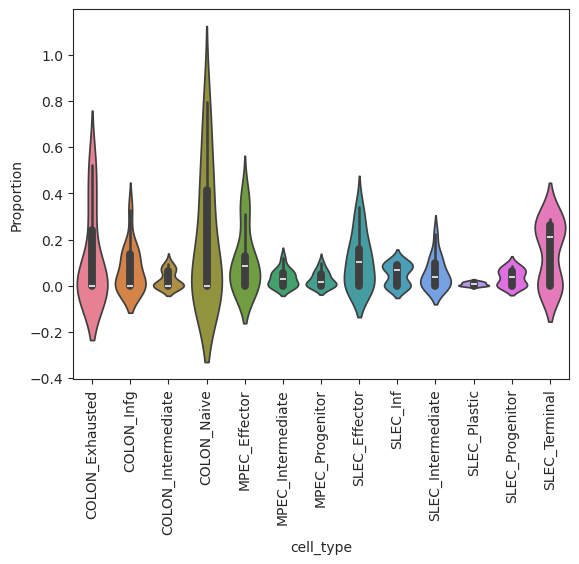

In [32]:
ax = sns.violinplot(plot_df, x="cell_type", y="Proportion", hue="cell_type")
ax.tick_params(axis="x", rotation=90)

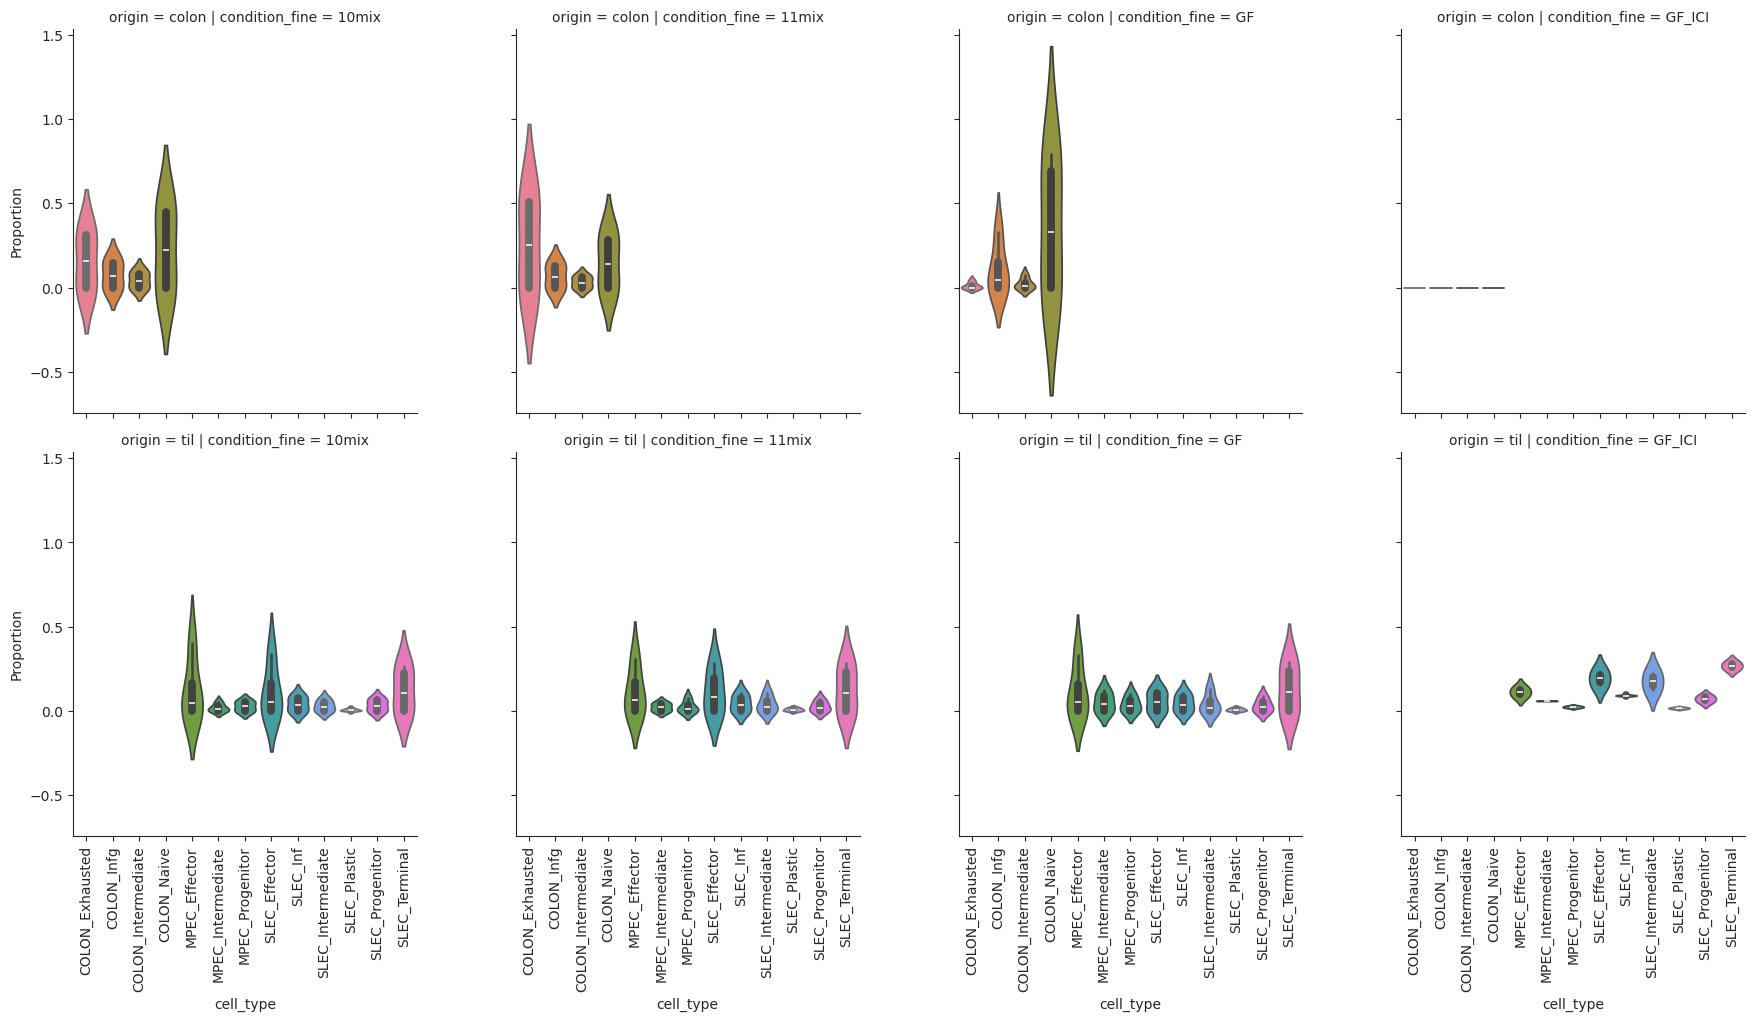

In [33]:
g = sns.FacetGrid(
    plot_df, col="condition_fine", row="origin", hue="cell_type", height=4.5
)
g.map(sns.violinplot, "cell_type", "Proportion")
g.tick_params(axis="x", rotation=90)

In [34]:
sns.set_context("talk", font_scale=0.9)

In [35]:
set(plot_df.cell_type)

{'COLON_Exhausted',
 'COLON_Infg',
 'COLON_Intermediate',
 'COLON_Naive',
 'MPEC_Effector',
 'MPEC_Intermediate',
 'MPEC_Progenitor',
 'SLEC_Effector',
 'SLEC_Inf',
 'SLEC_Intermediate',
 'SLEC_Plastic',
 'SLEC_Progenitor',
 'SLEC_Terminal'}

In [36]:
order = [
    "COLON_Naive",
    "COLON_Intermediate",
    "COLON_Infg",
    "COLON_Exhausted",
    "MPEC_Progenitor",
    "MPEC_Intermediate",
    "MPEC_Effector",
    "SLEC_Progenitor",
    "SLEC_Plastic",
    "SLEC_Intermediate",
    "SLEC_Effector",
    "SLEC_Inf",
    "SLEC_Terminal",
]

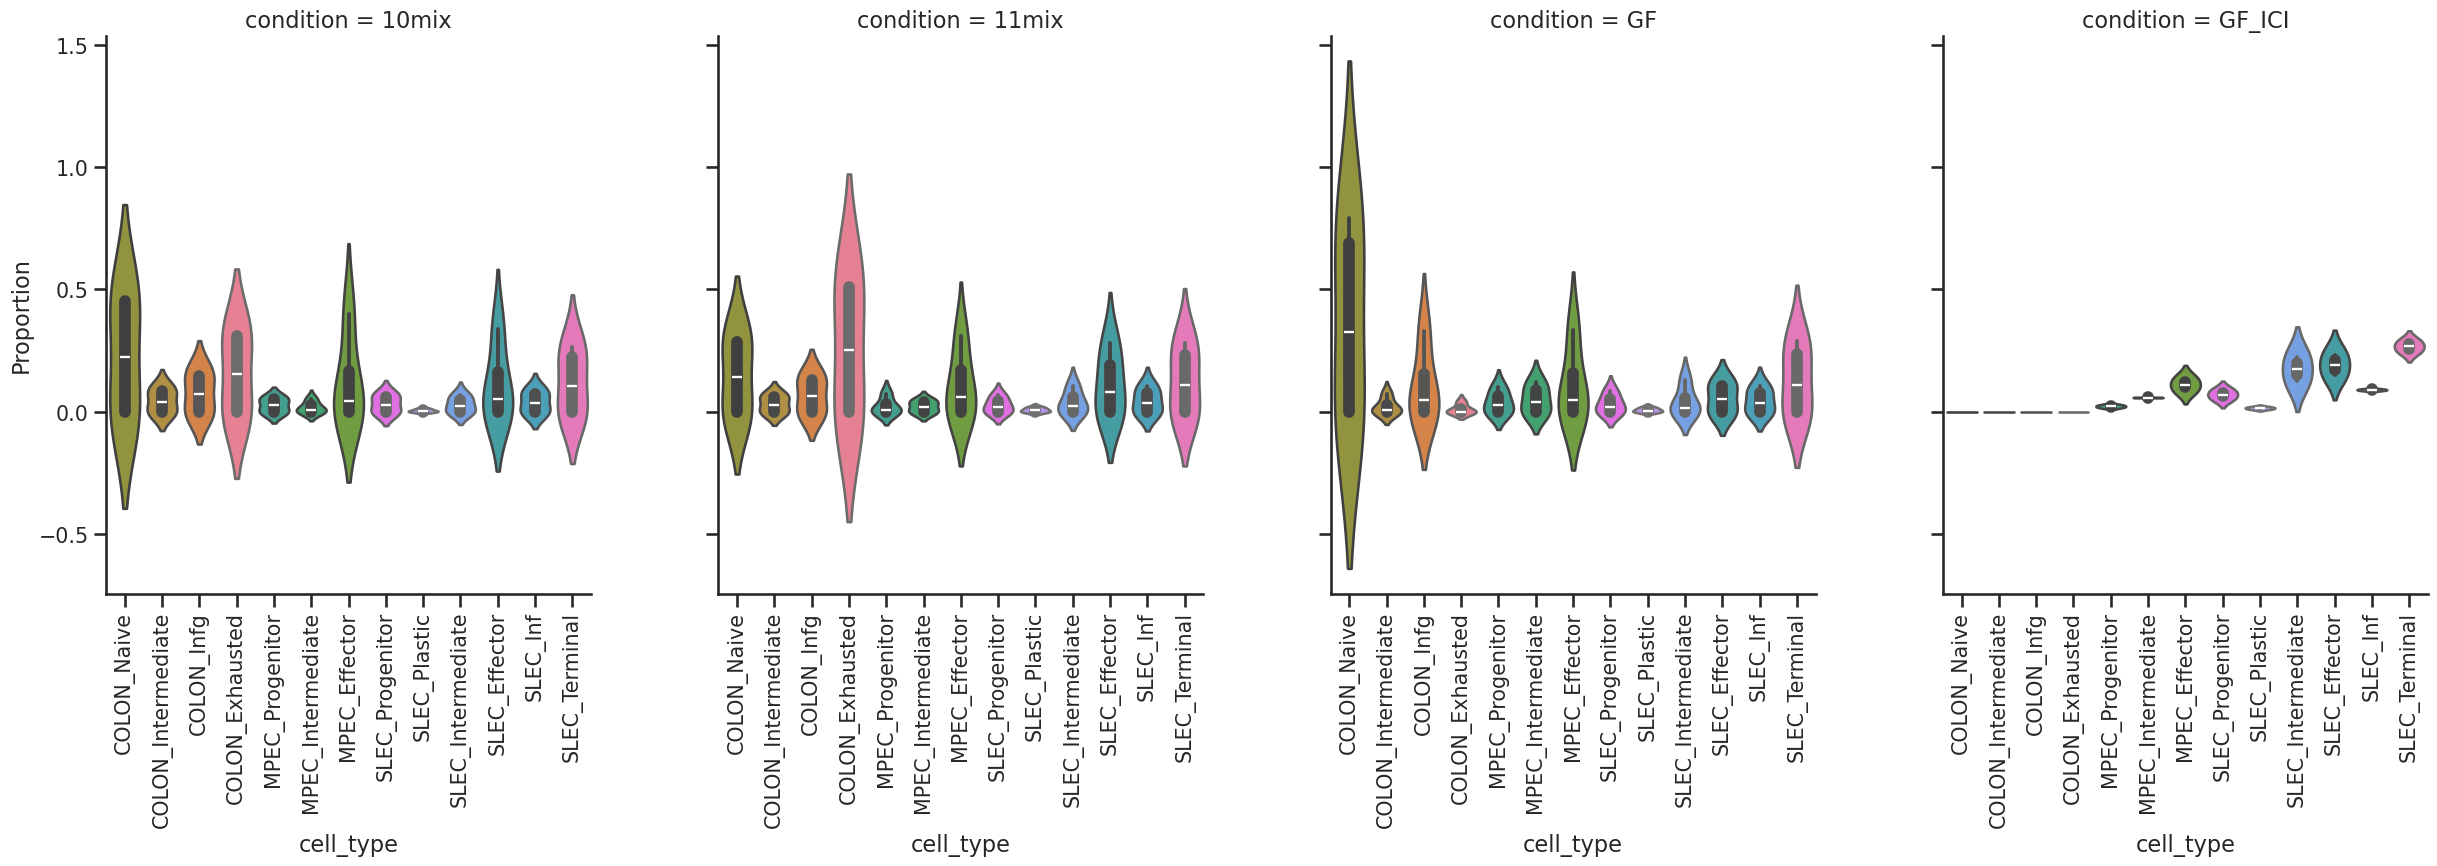

In [37]:
g = sns.FacetGrid(plot_df, col="condition", hue="cell_type", height=7, aspect=0.9)
g.map(sns.violinplot, "cell_type", "Proportion", order=order)
g.tick_params(axis="x", rotation=90)

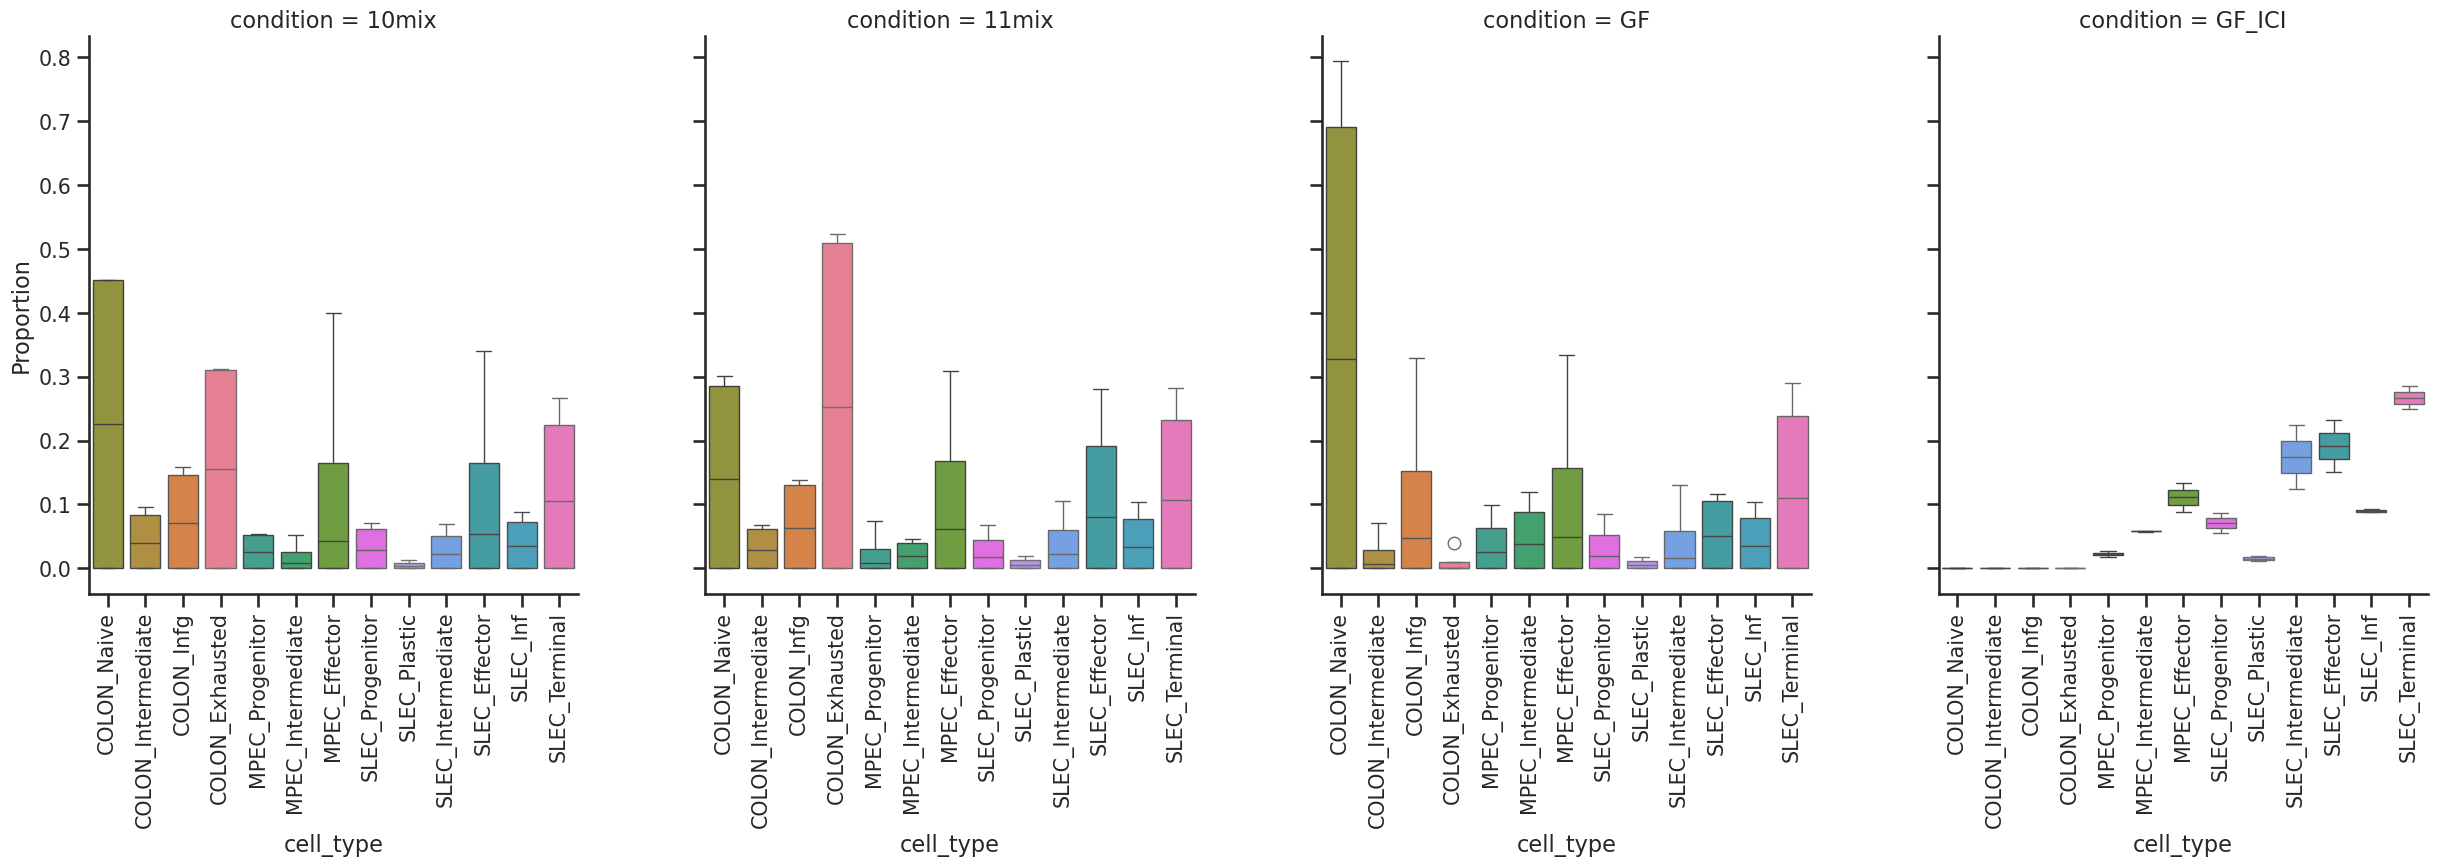

In [38]:
g = sns.FacetGrid(plot_df, col="condition", hue="cell_type", height=7, aspect=0.9)
g.map(sns.boxplot, "cell_type", "Proportion", order=order)
g.tick_params(axis="x", rotation=90)

In [39]:
frac_by_condition["origin"] = frac_by_condition["cell_type"].apply(
    lambda x: "colon" if "COLON" in x else "til"
)

In [56]:
set(frac_by_condition.condition)

{'10mix', '11mix', 'GF', 'GF-plus'}

In [54]:
bar_df = pd.DataFrame(frac_by_condition.groupby("condition")["n_cells"].sum())

In [63]:
bar_df

,n_cells
condition,
10mix,19110
11mix,18726
GF,11014
GF-plus,11609


In [51]:
order = [
    "10mix1",
    "10mix2",
    "11mix1",
    "11mix2",
    "GF1",
    "GF2",
    "10mix_ICI1",
    "10mix_ICI2",
    "11mix_ICI1",
    "11mix_ICI2",
    "GF_ICI1",
    "GF_ICI2",
    "GF_ICI1_plus",
    "GF_ICI2_plus",
]

In [66]:
order = ['GF', 'GF-plus',
 '10mix', '11mix', 
]

[Text(0, 0.5, 'Total number of cells'), Text(0.5, 0, '')]

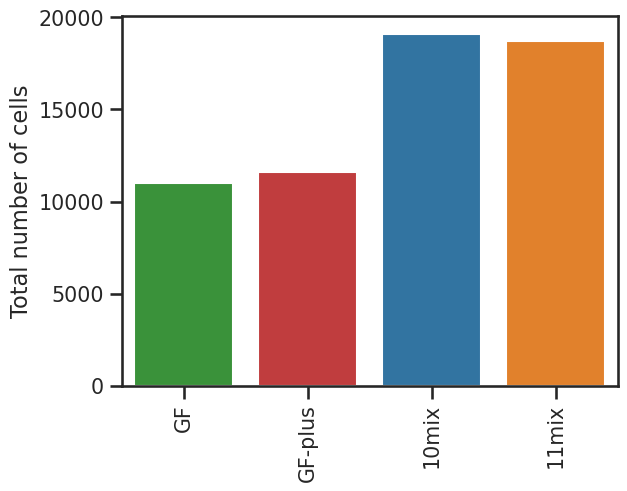

In [67]:
g = sns.barplot(bar_df, x="condition", y="n_cells", hue="condition", order = order)
g.tick_params(axis="x", rotation=90)
g.set(ylabel="Total number of cells", xlabel="")

In [ ]:
g = sns.FacetGrid(bar_df, col="condition", hue="cell_type", height=7, aspect=0.9)
g.map(sns.boxplot, "cell_type", "n_cells", order=order)
g.tick_params(axis="x", rotation=90)
g.set_axis_labels("", "Total number of cells")

In [ ]:
sum(frac_by_condition.n_cells)

In [ ]:
frac_by_condition

In [ ]:
g = sns.barplot(frac_by_condition, x="cell_type", y="n_cells", order=order)
g.tick_params(axis="x", rotation=90)

In [ ]:
g = sns.FacetGrid(
    frac_by_condition, col="condition", hue="cell_type", height=7, aspect=0.9
)
g.map(sns.boxplot, "cell_type", "n_cells", order=order)
g.tick_params(axis="x", rotation=90)
g.set_axis_labels("", "Mean number of cells")

In [ ]:
path = "/data/scratch/kvalem/projects/2021/honda_microbial_metabolites_2021/40_tables/40_single-cell-sorted-cd8/40_gex_surface_prot/compositional"

In [ ]:
plot_df.to_csv(f"{path}/plot_df.csv")

In [ ]:
frac_by_condition.to_csv(f"{path}/frac_by_condition.csv")

## Interferon positive cells 

In [ ]:
sc.pl.umap(adata, color="Ifng", vmax="p99", vmin=0.1, cmap="Reds")

In [ ]:
sc.pl.umap(adata, color="Cxcr3", vmax="p99", cmap="Reds")

In [ ]:
adata

In [ ]:
adata.obs["cell_type_seed"] = score_seeds(
    adata,
    {
        "Interferon": {
            "positive": [["Ifng"]],
            "negative": [[""]],
        }
    },
)

In [ ]:
adata.obs.cell_type_seed.value_counts()

In [ ]:
sc.pl.umap(adata, color="Ifng", gene_symbols="gene_name", cmap="Reds")

In [ ]:
adata_interferon = adata[adata.obs["cell_type_seed"] == "Interferon"]

In [ ]:
adata_interferon

In [ ]:
adata

In [ ]:
adata.var

In [ ]:
sc.pl.umap(adata, color=["Gzmk", "Il7r", "Layn"], vmax="p99", cmap="Reds")

In [ ]:
adata[adata.obs["cell_type"] == "SLEC_Ifn"]

In [ ]:
sc.pl.umap(adata, color="cell_type_seed", groups="Interferon")

In [ ]:
sc.pl.umap(adata, color="cell_type_seed", groups="Cxcr3")

In [ ]:
sc.pl.umap(adata, color="cell_type", groups="SLEC_Ifn")

In [ ]:
adata_interferon

In [ ]:
# adata_interferon.write_h5ad("adata_interferon.h5ad")

In [ ]:
adata = adata_interferon

In [ ]:
frac_by_condition = (
    adata.obs.groupby(["condition", "sample_id"])
    .apply(lambda x: x.value_counts("cell_type", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)

In [ ]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["sample_id", "condition"],
        columns="cell_type",
        values="n_cells",
    ).reset_index()
    # .drop(columns="other")
)

In [ ]:
data_all = dat.from_pandas(frac_pivot, covariate_columns=["condition", "sample_id"])

In [ ]:
data_all.obs["condition"] = pd.Categorical(
    data_all.obs["condition"], categories=["10mix", "11mix", "GF"]
)

In [ ]:
data_all._sanitize()

In [ ]:
data = data_all
feature_name = "sample_id"
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X / sample_sums
value_name = "Proportion"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).merge(
    data.obs[feature_name], left_index=True, right_index=True
)
plot_df = pd.melt(
    count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name
)

In [ ]:
plot_df["condition"] = plot_df["sample_id"].apply(
    lambda x: "10mix" if "10mix_ICI" in x else ("11mix" if "11mix_ICI" in x else "GF")
)

In [ ]:
plot_df["treatment"] = plot_df["sample_id"].apply(
    lambda x: "naive" if x in ["GF_ICI1_plus", "GF_ICI2_plus"] else "treated"
)

In [ ]:
plot_df.rename(columns={"Cell type": "cell_type"}, inplace=True)

In [ ]:
plot_df.cell_type.unique()

In [ ]:
frac_by_condition.to_csv("frac_by_condition_INF.csv")

In [ ]:
plot_df.to_csv("plot_df_INF.csv")